In [1]:
import os   
os.chdir("../")  
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="data/ironia-data-dfc6335a0abe.json"
os.getcwd()

#%pip install -r requirements.txt


'd:\\Documentos\\Universidad\\Cuarto\\Big data Project\\Git\\IronIA-RoboAdvisor'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
import datetime
from datetime import date
from datetime import timedelta
from dateutil.relativedelta import relativedelta

plt.rcParams["figure.figsize"] = (18,5)

from google.cloud import bigquery


In [4]:
client = bigquery.Client()

# Loading Datasets
In this part we are initializing our request for each of the tables in our dataset.

In [ ]:
# RATIOS
sql_ratios = """
    SELECT * FROM `ironia-data.Ironia_Ext.ratios` LIMIT 1000
"""
df_ratios = pd.read_gbq(sql_ratios)

# CATEGORIES
sql_categories = """
    SELECT * FROM `ironia-data.Ironia_Ext.categories` LIMIT 1000
"""
df_categories = pd.read_gbq(sql_categories)

# PRECIOS
sql_precios = """
    SELECT * FROM `ironia-data.Ironia_Ext.precios` LIMIT 1000
"""
df_precios = pd.read_gbq(sql_precios)


### Exploratory analysis with one sample

In [ ]:
df_precios.loc[df_precios["Ironia_id"]==41319]

,Ironia_id,currency,date,nav,name
0,41319,CAD,2020-03-31,1.1659,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
2,41319,CAD,2017-09-12,0.9933,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
3,41319,CAD,2020-01-28,1.3768,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
4,41319,CAD,2019-08-21,1.2501,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
5,41319,CAD,2019-06-14,1.2404,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
6,41319,CAD,2017-10-02,1.0337,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
7,41319,CAD,2017-09-04,0.9980,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
8,41319,CAD,2020-03-05,1.3086,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"


In [ ]:
sql = "SELECT nav,date FROM `ironia-data.Ironia_Ext.precios` WHERE Ironia_id=41319 LIMIT 10000 "
df = pd.read_gbq(sql)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by="date")
df.set_index(df["date"],inplace=True)
df.drop("date",axis=1,inplace=True)
df.head(10)

,nav
date,
2017-07-19,1.0041
2017-07-20,1.0005
2017-07-21,0.9961
2017-07-24,0.9946
2017-07-25,0.9991
2017-07-26,0.9997
2017-07-27,0.9971
2017-07-28,0.9872
2017-07-31,0.9927


In [ ]:
df["nav return"] = (df["nav"]-df["nav"].shift(1))/df["nav"].shift(1)
df["nav return"][0] = 0
risk = 0.05
VaR = np.percentile(df["nav return"],risk*100) #VaR at 5% risk
CVaR = np.mean(df["nav return"].loc[df["nav return"]<=VaR])
df

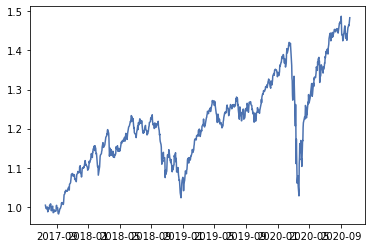

In [ ]:
plt.plot(df["nav"])

In [ ]:
max_acum = df["nav"].cummax()
max_acum.head(5)

date
2017-07-19    1.0041
2017-07-20    1.0041
2017-07-21    1.0041
2017-07-24    1.0041
2017-07-25    1.0041
Name: nav, dtype: float64

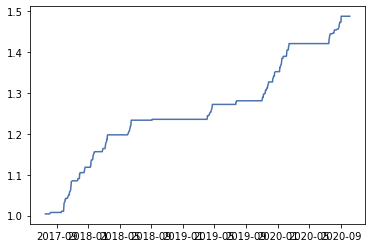

In [ ]:
plt.plot(max_acum)

In [ ]:
df["drawdown"] = -(df["nav"]-max_acum)/max_acum
df.head(5)

,nav,nav return,drawdown
date,,,
2017-07-19,1.0041,0.000000,-0.000000
2017-07-20,1.0005,-0.003585,0.003585
2017-07-21,0.9961,-0.004398,0.007967
2017-07-24,0.9946,-0.001506,0.009461
2017-07-25,0.9991,0.004524,0.004980


Max drawdown: 0.2764324933126848


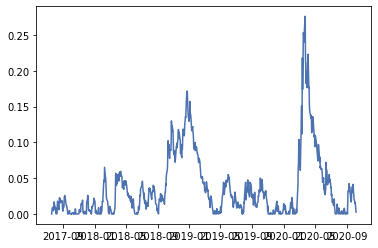

In [ ]:
#Ask if we have to put the drawdown in positive or negative
plt.plot(df["drawdown"])
MDD =  np.max(df["drawdown"].values)
print("Max drawdown:", MDD)


In [ ]:
recovery_factor = df["nav"].iloc[-1]/np.max(df["drawdown"].values)
recovery_factor   

5.367314031066972

In [ ]:
DaR = np.percentile(df["drawdown"],0.7*100)
CDaR = np.mean(df["drawdown"].loc[df["drawdown"]<=DaR])

In [ ]:
MAD = df["nav return"].mad()

In [ ]:
df2 = pd.DataFrame({"Ironia_id": [41319],
                               "MDD": [MDD],
                            "DaR":[DaR],
                           "CDaR": [CDaR],
                         "RF": [recovery_factor],
                          "VaR": [VaR],
                            "CVaR": [CVaR],
                    "MAD":[MAD]})



In [ ]:
df2

,Ironia_id,MDD,DaR,CDaR,RF,VaR,CVaR,MAD
0,41319,0.276432,0.040145,0.013135,5.367314,-0.013824,-0.025778,0.006793


# Dataframe pipeline
Here we are creating a dataframe with all the data we need and we are calculating some data that we need to keep going with the project.

In [7]:
from src.dataframe_pipeline import generate_df
from src.dataframe_pipeline import get_train_test_prices

In [ ]:
ids_sql = 'SELECT DISTINCT Ironia_id,name FROM `ironia-data.Ironia_Ext.precios`  WHERE currency="EUR"  LIMIT 10'
ids_sql = 'SELECT DISTINCT allfunds_id FROM `ironia-data.Ironia_Ext.ratios` LIMIT 200'
ids_df = pd.read_gbq(ids_sql)
ids = ids_df.values.tolist()

In [ ]:
with open('/content/drive/MyDrive/IronIA/working_dates.txt') as f:
    contents = f.read()
working_dates = contents.split("\n")[:-1] #Working dates just for train

with open('/content/drive/MyDrive/IronIA/working_dates_train&test.txt') as f:
    contents = f.read()
working_dates_traintest = contents.split("\n")[:-1] #Working dates for both

In [ ]:
train,test = get_train_test_prices(ids,working_dates_traintest,delta=30,print_every=10)

#train.to_csv(r"/content/drive/MyDrive/IronIA/prices_train.csv")
#test.to_csv(r"/content/drive/MyDrive/IronIA/prices_test.csv")

#If train/test computed:
#train = pd.read_csv("/content/drive/MyDrive/IronIA/prices_train.csv")
#test = pd.read_csv("/content/drive/MyDrive/IronIA/prices_test.csv")

10 out of 200
20 out of 200
30 out of 200
40 out of 200
50 out of 200
60 out of 200
70 out of 200
80 out of 200
90 out of 200
100 out of 200
110 out of 200
120 out of 200
130 out of 200
140 out of 200
150 out of 200
160 out of 200
170 out of 200
180 out of 200
190 out of 200
200 out of 200


In [ ]:
train 

,"LO SELECTION THE GLOB ""M"" (CHFHDG)","FIDELITY GLB FINANCL SERVS ""Y""(EUR) ACC","BGF NUTRITION ""D4"" (GBPHDG) D","NN (L) BANKING & INSURANCE ""X"" ACC","BGF NUTRITION ""D2"" (GBPHDG)","BGF NUTRITION ""D2"" (EURHDG)","LO SELECT THE GLB FIX INC OPP ""M""(EUR)","FIDELITY GB FIN SERVICES ""Y"" (EUR) D","SANTALUCIA IBERICO AC ""B"" (EUR)","BGF SUSTAINABLE ENERG ""D4R"" (GBP) D","MAGALLANES VAL INV UC-IBER EQ ""R"" (EUR)","MAGALLANES VAL INV UC-IBER EQ ""I"" (EUR)","BGF SUSTAINABLE ENERG ""ADS"" (GBP) D","BGF NUTRITION ""A2"" (USD)","FRANKLIN BIOTEC DISCOVERY ""W"" (USD)","SANTALUCIA ESPABOLSA ""A"" (EUR) ACC","GESCONSULT RENTA VARIABLE ""A"" FI","BGF WORLD FINANCIALS ""D2""","FRANKLIN BIO DISC ""A"" (CHFHDG)","MAINFIRST GERMANY ""D"" (EUR) D","POLAR CAP FINANCIAL OPP ""I"" (GBP) D","FIDELITY IBERIA ""E"" (EUR) ACC","BNP GER MULTI-FACTOR EQ ""C"" (EUR) ACC","DPAM INV B EQ SUST FOD TRENDS""V""(EUR)INC","CAPITAL AT WORK CORPORATE BONDS ""C""","MIRABAUD CONVERTIBLE BD EUROP ""A"" (EUR)","BGF SUSTAINABLE ENERG ""C2"" (EUR)","DWS INVEST GERMAN EQ ""FC"" (USDHDG) ACC","SABADELL ESPANA 5 VALORES ""PLUS""","SANTANDER INDICE ESPANA ""B"" (EUR)","AXA WF FRAMLINGTON ITALY ""I"" ACC","FIDELITY ITALY ""A"" D","OYSTER ITALIAN OPPORT ""N"" (EUR)","DWS INVEST GERMAN EQ ""FC"" (EUR) ACC","EURIZON FUND - ITALIA ""Z"" (EUR)","JSS INVFONDS-JSS SUST EQ-WATER ""P"" INC","DPAM INV B EQ SUST FOD TRENDS""F""(EUR)ACC","BGF SUSTAINABLE ENERG ""D2"" (EUR)","OKAVANGO DELTA FI ""A"" (EUR)","MARCH INTERNATIONAL - ""P"" (EUR) A","BNP EUR SM C CONV ""C"" (EUR) INC","BGF NUTRITION ""D4"" (EURHDG) D","LO SELECTION THE GLOB ""P"" (CHFHDG)","AXA WF FRAMLINGTON ITALY ""A"" ACC","BNP PARIBAS AQUA ""C"" (EUR) ACC","FRANKLIN BIOTECHNOLOGY DISCOVERY FUND""I""","UBAM EURP 10-40 CONV BD ""A"" (EUR) ACC","POLAR CAP FINANCIAL OPP ""I"" (EUR) D","FIDELITY GLB FINANCL SERVS ""A"" (USDHDG)","CREDIINVEST SPANISH VALUE ""I3"" (USDHDG)","FRANKLIN BIOTECHNOLOGY DISCOVERY ""N""","BBVA BOLSA EUROPA FINANZAS, FI","DPAM INV B EQ SUST FOD TRENDS""B""(EUR)ACC","SABADELL ESPAÐA BLS, FI ""BASE"" (EUR) ACC","AMUNDI EUR CON BD ""F2"" (EUR) ACC","BNP PARIBAS EUROPE CONVERTIBLE ""P"" (EUR) ACC","BNP PARIBAS AQUA ""P"" (EUR) ACC","BNP EUR SM C CONV ""C"" (EUR) ACC",DWS AKTIEN STRATEGIE DEUTSCHLAND,"GUINNESS SUSTAINABLE ""C"" (EUR)","AMND FNDS EURPEAN CONV BND ""IE""(EUR)A","FIDELITY FRANCE ""A"" D","FIDELITY ITALY ""A"" (EUR)",MAGALLANES IBERIAN EQUITY FI CLASE P
2016-01-04,109.9778,16.96,10.60,535.870,7.180000,11.060000,107.6200,13.700,9.132337,5.19,99.98000,99.980000,5.05,11.280000,14.82,26.300038,37.675918,20.79,16.03,72.310000,8.110000,41.79,241.600000,116.840000,266.890,137.940000,5.76,93.380000,10.482873,92.28060,97.12,36.78,188.14,164.310000,101.87,161.620,130.350000,7.400000,15.749738,9.992220,130.48,10.680000,108.408600,199.460000,97.070,21.37,125.180000,11.020000,9.583,9.1577,28.09,296.829738,123.30,10.737929,119.39,122.770,143.680,163.69,336.890000,9.162300,1271.1400,48.870,13.89,110.639309
2016-01-05,110.0500,17.11,10.52,535.860,7.130000,10.990000,107.7100,13.820,9.168558,5.21,100.40000,100.410000,5.07,11.200000,14.85,26.400268,37.744679,20.80,16.06,72.850000,8.100000,41.90,242.070000,116.680000,267.650,136.560000,5.81,93.410000,10.627201,92.49252,97.98,37.20,189.27,164.290000,102.88,162.470,130.180000,7.470000,15.809005,9.831760,130.90,10.610000,108.478000,201.210000,97.590,21.41,125.350000,11.060000,9.622,9.0074,28.15,298.270177,123.13,10.772928,119.43,122.850,144.450,164.23,335.990000,9.216100,1271.6400,49.060,14.05,110.947459
2016-01-06,110.2746,16.90,10.40,528.420,7.050000,10.870000,107.9500,13.650,8.957587,5.16,99.63000,99.640000,5.02,11.080000,14.47,26.070224,37.148705,20.42,15.65,71.730000,8.040000,41.48,239.610000,114.290000,267.750,136.620000,5.73,91.600000,10.442872,91.13622,96.13,36.36,185.17,161.120000,100.52,160.100,127.500000,7.370000,15.378967,9.839680,130.30,10.490000,108.697600,197.405000,96.070,20.87,125.010000,10.930000,9.523,9.0155,27.44,292.356083,120.60,10.5

In [ ]:
#df_main,prices_df_main = generate_df(ids,working_dates,period=3)
#df_main.to_csv(r"/content/drive/MyDrive/IronIA/ratios.csv")
#prices_df_main.to_csv(r"/content/drive/MyDrive/IronIA/prices.csv")

#If dataset computed:
df_main = pd.read_csv("/content/drive/MyDrive/IronIA/ratios.csv")
prices_df_main = pd.read_csv("/content/drive/MyDrive/IronIA/prices_train.csv")

prices_df_main

,Unnamed: 0,"SANTANDER ACCIONES ESPANOLAS ""B""","BK FUTURO IBEX, FI",BBVA BOLSA FI,"METAVALOR, FI","SABADELL ES 5 VALORES, FIL ""BASE"" (EUR)","FIDELITY IBERIA ""A"" (EUR) ACC","SABADELL ESPANA BOLSA, PLUS",BBVA BOLSA INDICE FI,BBVA BOLSA PLUS FI,"SANTANDER ACCIONES ESPANOLAS, FI ""A""","SABADELL ESPANA 5 VALORES ""PRERMIER""","IMANTIA RV IBERIA, FI (EUR) ACC","PIMCO CREDIT OPPORTUN ""E"" (EURHDG)","SCHRODER ISF EUR MKT NEUT ""A1"" (EUR) ACC","EDR SICAV START ""A"" (EUR) ACC","SCHRODER GAIA EGERTON EQUITY ""C"" (EUR) D","SCH ISF START BD ""C"" (USD) INC AV","ROBECO QI LONG/SHORT ""DH"" (USDHDG)","NEUBERGER BERMAN US LS EQ ""A1"" (USD)","SCHRODER GAIA SIRIOS US EQUITY ""C"" (USD)","JPM US OPP LS EQ ""A"" (PERF)(EURHDG)","JANUS HENDERSON ABSOL ""U"" (USD) D","JPM EURP EQ ABST ALPHA ""A PERF"" (EUR)ACC","SCHRODER GAIA BLUE TREND ""A"" (EURHDG)","CANDRIAM DIVERSIFIED FUTURES ""C"" ACC","SCHRODER ISF EUROP EQ ABS RT ""B"" (EUR)","MAN GLG EUR EQ ALT ""INH"" (GBPHDG)",PIMCO EM SHORT-T LCAL CURR 'I' (EUR) ACC,"MERIAN GLOBAL EQUITY ""A"" (USD)","SCHRODER GAIA SIRIOS US EQ ""C"" (EURHDG)","ROBECO QI LONG/SHORT ""DH"" (EURHDG)","PIMCO CREDIT OPPORTUN ""E"" (USD)","SCHRODER ISF EUROP EQ ABS RT ""C"" (EUR)","UBS (IRL) EQ OPP LONG SHORT ""P"" (EUR)","LA FRANCAISE ALLOCATION ""R"" (EUR) ACC","NN (L) FCMA PREMIUM ""P"" (EUR) AC","BNY MELLON GLB REAL RET (EUR) ""A"" D","SCHRODER ISF EUR ALPHA ABS RT ""C"" (EUR)","JANUS HENDERSON ABSOL ""A"" (CHFHDG)",...,"SCHRODER ISF QEP GB VAL PLUS ""C"" (GBP)","DEKA-EUROPA NEBENWERTE ""TF"" (EUR) INC","PICTET EUROPEAN EQ SEL ""I"" (EUR) D DY","OYSTER EUROPEAN SELECTION ""R"" (EUR)",OYSTER EUROP SEL 'C CHF HP' (CHFHDG) ACC,OYSTER EUROP SELECT 'C EUR' (EUR) ACC,"PICTET EUROPEAN EQ SELECTION ""P"" INC","PICTET EUROPEAN EQ SELECTION ""I"" ACC","ALLIANZ ASIA PACIFIC EQUITY ""I"" (EUR) D","MELCHIOR ASIAN OPPORTUNITIES ""B2"" (USD)","SCHRODER ISF EUROPEAN OPPORTUNITIES ""C""","SCHRODER ISF EUROPEAN OPPORTUNITIES ""A""","SCHRODER ISF EUR OPPORT ""A1""(EUR)","SCH ISF EUR OPP ""C"" (GBP) INC SV","AMUNDI EQ ASEAN ""AU"" (USD) ACC","ALLIANZ GBL AGRICUL TRDS ""AT"" (USD) ACC","AMUNDI EQ ASEAN ""IU"" (USD) ACC","SCHRODER ISF ALTERNAT ""C"" (USD)","CANDRIAM SUST EUR BD ""I"" (EUR) D","SANTALUCIA RENTA FIJA DINAMICA FI, ""B""","BNY MELLON US DYNAMIC VALUE ""C"" (USD)","GBM ASSET MANAGEMENT ""J"" (USD)","DPAM INV B EQ WLD DIV""W"" (EUR) ACC","DPAM INV B EQ WLD DIV""A"" (EUR) INC","SCH ISF UK OPP ""A"" (EUR) INC SV","SCH ISF UK OPP ""A"" (USD) INC SV","SCHRODER ISF EUR OPP ""C"" (USDHDG)","MIRAE ASSET ASIA SEC LEADER EQ ""I"" (EUR)","CANDRIAM SUST WORLD BDS ""I"" (EUR)","SANTANDER AM BRAZILIAN EQUITY ""B"" ACC","BROWN ADVISORY AMERICAN ""A"" (USD) D","BROWN ADVISORY AMERICAN ""B"" (GBP) D","BROWN ADVISORY AMERICAN ""A"" (GBP) D","GENERALI EUROPEAN EQ RECOVERY ""B"" (EUR)","GENERALI EUROPEAN EQ RECOVERY ""D"" (EUR)","GENERALI EUROPEAN EQ RECOVERY ""E"" (EUR)","ALLIANZ ADVANCED FIXE ""RT"" (EUR)","VANGUARD PACIFIC EX J ""IP"" (EUR) ACC",VANGUARD PACIFIC EX-JAPAN STOCK INDEX,"VANGUARD PACIFIC EX J ""IP"" (GBP) D"
0,2016-01-04,20.17688,98.29002,22.955176,488.520320,10.471177,15.40,10.768149,20.501077,1389.374225,18.34742,10.506308,22.738956,9.590,120.5000,540.900,170.020000,108.390000,108.150000,9.740,123.55,88.45,9.680,124.82,98.740000,10012.940,104.460000,117.300000,11.93,1.172500,123.610000,109.190000,9.64,106.880000,111.63,126.700,294.19,1.03490,108.730000,9.639568,...,119.8100,69.16,611.470000,1950.410000,140.050000,160.97,525.410000,630.000000,22.470000,82.551810,116.970000,115.190000,114.230000,99.070000,77.67,11.100000,820.0300,97.090000,277.19,12.506435,2.46380,8.97,177.85,163.570,96.250000,75.230000,111.060000,8.21,3378.350,34.128200,16.82,16.84,26.67,96.7460,94.702,93.7020,97.800,111.6893,186.3651,84.8362
1,2016-01-05,20.18776,98.47840,22.988934,489.571555,10.615271,15.44,10.803395,20.549058,1393.159704,18.35709,10.651018,22.791609,9.610,120.7500,540.940,170.130000,108.340000,108.350000,9.750,123.96,88.16,9.690,124.9

# Linear Problem Approach



### Pyportfolio opt Library

https://pyportfolioopt.readthedocs.io/en/stable/_modules/pypfopt/efficient_frontier/efficient_cvar.html

https://pyportfolioopt.readthedocs.io/en/latest/_modules/pypfopt/efficient_frontier/efficient_cdar.html


In [ ]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientCVaR,EfficientCDaR
from pypfopt.discrete_allocation import DiscreteAllocation,get_latest_prices
from pypfopt import objective_functions

from pypfopt.efficient_frontier import EfficientCVaR,EfficientCDaR
from pypfopt.discrete_allocation import DiscreteAllocation,get_latest_prices
from pypfopt import objective_functions
import cplex
# Checking the available solvers
import cvxpy
cvxpy.installed_solvers()

In [13]:
train = pd.read_csv("prices_train.csv")
train.set_index("Unnamed: 0",inplace=True)
train.index.name= 'date'
train = train.sample(n=1000,axis=1,random_state=40)


portfolio = train
mu = mean_historical_return(portfolio)

In [14]:
portfolio

,"INVESCO PAN EUROPEAN STRUCTURED EQ ""E""","INVESCO REAL RETN (EUR) BD ""C"" (EUR) ACC","PIMCO EURO INCOME BOND ""E"" (EUR) INC","LEGG MASON WESTERN ASSET MACRO OPPORTUNITIES BOND ""X"" (USD) INC",FRANKLIN GLOBAL FUNDAMENTAL STRATEGIES A,"PRIVILDG WELL LG CAP US RSEARCH ""N""(USD)","GAM STAR (LUX) CONVERTIBL ALPH ""D"" (EUR)","FRANKLIN K2 ALTERNATIVE STRAT ""I"" (USD)","ARTEMIS FUNDS (LUX) U ""FI"" (USD) A","CANDRIAM SUSTAINABLE MEDIUM ""C"" INC",...,"INVESCO PAN EUR STRUCT EQ ""A"" (EURHDG)","GAM MULTISTOCK ABSOLU ""A"" (CHFHDG) D","EI STURDZA STRTGC EURP QL ""I"" (EUR) A","THREADNEEDLE EMERG MRKT LOC ""1"" RNI D","MAN GLG EUROPEAN MID- ""INF"" (EUR)","BLENDED RESEARCH EURP EQ ""A1"" (USD) ACC",IMANTIA FUTURO HEALTH (EUR),"M&G (LUX) EURO ST VAL ""A"" (USD)","SABADELL BONOS EMERGENTES, PLUS","AXA WF EURO CREDIT PLUS ""E"" (EUR)Q D"
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,14.82,16.317900,10.140,97.65,12.11,14.528600,98.370000,10.32,0.682660,5.5536,...,11.40,107.430,184.580,1.0971,103.17,12.70,52.134332,7.83849,14.935152,102.340
2016-01-05,14.85,16.263900,10.140,97.71,12.12,14.540900,98.220000,10.32,0.681340,5.5090,...,11.40,107.450,180.110,1.0931,103.28,12.56,52.285922,7.74354,15.076784,102.430
2016-01-06,14.81,16.257800,10.140,97.80,11.98,14.320400,98.030000,10.28,0.673380,5.4321,...,11.37,107.360,181.360,1.0892,103.02,12.49,51.838802,7.74065,15.031524,102.500
2016-01-07,14.39,16.248300,10.090,97.26,11.80,14.012600,97.380000,10.21,0.661020,5.3924,...,11.12,107.150,179.970,1.0860,102.72,12.26,51.259786,7.53279,14.803269,102.220
2016-01-08,14.53,16.277300,10.090,97.08,11.70,13.814300,97.200000,10.20,0.658830,5.3708,...,11.22,106.970,176.740,1.0880,102.68,12.13,50.884572,7.59579,14.796047,102.270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,14.06,16.285267,9.900,99.57,12.75,17.501233,98.763333,11.08,0.898433,5.3765,...,11.95,89.310,183.330,1.0107,112.66,14.14,47.573086,8.22620,15.405859,103.320
2018-12-26,14.00,16.272433,9.905,99.33,12.98,17.684967,98.826667,11.19,0.893467,5.3900,...,11.90,89.485,182.775,1.0099,112.72,14.19,47.970249,8.18955,15.477238,103.350
2018-12-27,13.94,16.259600,9.910,99.64,12.94,17.868700,98.890000,11.19,0.888500,5.4035,...,11.85,89.660,182.220,1.0091,112.78,14.24,47.655091,8.15290,15.370212,103.380


#### CVaR (No Market Neutrality)

In [ ]:
S = portfolio.cov()
ef_cvar = EfficientCVaR(mu, S,weight_bounds=(0,1),solver = 'ECOS_BB')     # Solvers :['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']
ef_cvar.add_objective(objective_functions.L2_reg, gamma=0.5)
cvar_weights = ef_cvar.efficient_risk(target_cvar=0.05,market_neutral=False)

cleaned_weights = ef_cvar.clean_weights()
print(dict(cleaned_weights))

latest_prices = get_latest_prices(portfolio)
ef_cvar.portfolio_performance(verbose=True)

budget = 100000
da_cvar = DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value=budget)

allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): ${:.2f}".format(leftover))

#### CDaR (No Market Neutrality)

In [9]:
S = portfolio.cov()
ef_cdar = EfficientCDaR(mu, S,weight_bounds=(0,1))   # Solvers :['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']

# ADD CONSTRAINTS
# ef_cdar.add_constraint(lambda x : x >= 0)

cvar_weights = ef_cdar.efficient_risk(target_cdar=0.20,market_neutral=False)

cleaned_weights = ef_cvar.clean_weights()
print(dict(cleaned_weights))

latest_prices = get_latest_prices(portfolio)
ef_cvar.portfolio_performance(verbose=True)

da_cvar = DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value=100000)

allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): ${:.2f}".format(leftover))

{'INVESCO PAN EUROPEAN STRUCTURED EQ "E"': 0.0, 'INVESCO REAL RETN (EUR) BD "C" (EUR) ACC': 0.00131, 'PIMCO EURO INCOME BOND "E" (EUR) INC': 0.0, 'LEGG MASON WESTERN ASSET MACRO OPPORTUNITIES BOND "X" (USD) INC': 0.0, 'FRANKLIN GLOBAL FUNDAMENTAL STRATEGIES A': 0.00828, 'PRIVILDG WELL LG CAP US RSEARCH "N"(USD)': 0.04473, 'GAM STAR (LUX) CONVERTIBL ALPH "D" (EUR)': 0.0, 'FRANKLIN K2 ALTERNATIVE STRAT "I" (USD)': 0.02545, 'ARTEMIS FUNDS (LUX) U "FI" (USD) A': 0.10841, 'CANDRIAM SUSTAINABLE MEDIUM "C" INC': 0.0, 'ASSI EM MKTS CORP BD I USD ACC': 0.04635, 'FRANKLIN US GOVERNMENT "I" D': 0.0, 'JAN HEN US VENTURE "A" (USD) ACC': 0.02037, 'GAM MULTISTOCK EMERGI "R" (CHF)': 0.0, 'BNP GER MULTI-FACTOR EQ "C" (EUR) INC': 0.0, 'DPAM INV B EQ EURLND "F" (EUR) ACC': 0.0, 'BNY MELLON GBAL HIGH YIELD BOND "C"(EUR)': 0.04279, 'BNY MELLON EM.MKT DEBT LCAL CUR "C"(EUR)': 0.02795, 'ECHIQUIER WORLD EQUITY GROWTH "A"': 0.0, 'ALLIANZ CAPITAL PLUS "CT" (EUR)': 0.0, 'VANGUARD GB ST BD IDX "I" (EURHDG)': 0.00

In [10]:
for key in cleaned_weights.keys():
  if cleaned_weights[key] > 0:
    print(key,':',cleaned_weights[key])

INVESCO REAL RETN (EUR) BD "C" (EUR) ACC : 0.00131
FRANKLIN GLOBAL FUNDAMENTAL STRATEGIES A : 0.00828
PRIVILDG WELL LG CAP US RSEARCH "N"(USD) : 0.04473
FRANKLIN K2 ALTERNATIVE STRAT "I" (USD) : 0.02545
ARTEMIS FUNDS (LUX) U "FI" (USD) A : 0.10841
ASSI EM MKTS CORP BD I USD ACC : 0.04635
JAN HEN US VENTURE "A" (USD) ACC : 0.02037
BNY MELLON GBAL HIGH YIELD BOND "C"(EUR) : 0.04279
BNY MELLON EM.MKT DEBT LCAL CUR "C"(EUR) : 0.02795
VANGUARD GB ST BD IDX "I" (EURHDG) : 0.00527
AMUNDI VOLATILITY EURO "F2" (EUR) ACC : 0.03344
FIDELITY CHINA FOCUS "Y" : 0.04275
MFS MERIDIAN US CORP BD "A1" (USD) ACC : 0.02347
LO FUNDS - ALL ROADS "P" (CHFHDG) ACC A : 0.01415
FRANKLIN K2 ALT STRATEGIES "I" (JPY) : 0.00014
BGF EURO SH DUR BD "A4R" (USDHGD) D : 0.02043
SCHRODER ISF GLOBAL EQUITY "B" : 0.01867
INVESCO EM MKT STRUC EQ "A" (USD) ACC : 0.05279
PIMCO CREDIT OPPORTUN "I" (USD) : 0.03673
BNY MELLON REAL RETUR "A" (GBP) D : 0.0008
THREAD (LUX) GL EM ST BD "AEH"ACC : 0.00521
ASSI EM MKTS CORP BD A USD A

In [11]:
S = CovarianceShrinkage(portfolio).ledoit_wolf()
ef = EfficientFrontier(mu, S,solver = 'ECOS_BB')   # Solvers :['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
# ef.save_weights_to_file("/content/drive/MyDrive/IronIA/weights.txt")  # saves to file
print(cleaned_weights)

latest_prices = get_latest_prices(portfolio)
ef.portfolio_performance(verbose=True)

da_cvar = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=100000)

allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): ${:.2f}".format(leftover))

OrderedDict([('INVESCO PAN EUROPEAN STRUCTURED EQ "E"', 0.0), ('INVESCO REAL RETN (EUR) BD "C" (EUR) ACC', 0.0), ('PIMCO EURO INCOME BOND "E" (EUR) INC', 0.0), ('LEGG MASON WESTERN ASSET MACRO OPPORTUNITIES BOND "X" (USD) INC', 0.0), ('FRANKLIN GLOBAL FUNDAMENTAL STRATEGIES A', 0.0), ('PRIVILDG WELL LG CAP US RSEARCH "N"(USD)', 0.0), ('GAM STAR (LUX) CONVERTIBL ALPH "D" (EUR)', 0.0), ('FRANKLIN K2 ALTERNATIVE STRAT "I" (USD)', 0.0), ('ARTEMIS FUNDS (LUX) U "FI" (USD) A', 0.0), ('CANDRIAM SUSTAINABLE MEDIUM "C" INC', 0.0), ('ASSI EM MKTS CORP BD I USD ACC', 0.43419), ('FRANKLIN US GOVERNMENT "I" D', 0.0), ('JAN HEN US VENTURE "A" (USD) ACC', 0.0), ('GAM MULTISTOCK EMERGI "R" (CHF)', 0.0), ('BNP GER MULTI-FACTOR EQ "C" (EUR) INC', 0.0), ('DPAM INV B EQ EURLND "F" (EUR) ACC', 0.0), ('BNY MELLON GBAL HIGH YIELD BOND "C"(EUR)', 0.0), ('BNY MELLON EM.MKT DEBT LCAL CUR "C"(EUR)', 0.0), ('ECHIQUIER WORLD EQUITY GROWTH "A"', 0.0), ('ALLIANZ CAPITAL PLUS "CT" (EUR)', 0.0), ('VANGUARD GB ST BD ID

In [12]:
weights_dict = {}
for key in cleaned_weights.keys():
  if cleaned_weights[key] > 0:
    print(key,':',cleaned_weights[key])
    weights_dict[key] = cleaned_weights[key]

ASSI EM MKTS CORP BD I USD ACC : 0.43419
NN (L) US ENH CORE CONCT EQ "P" (US) ACC : 0.00229
VANGUARD EURO GOV BD IDX "I" (USD) : 0.02476
FRONTIER MARKETS "R-CL" (EUR) ACC : 0.03766
PIMCO CREDIT OPPORTUN "I" (USD) : 0.30578
JAN HH GLOBAL TECHNOLOGY "A2" (GBP) ACC : 0.0394
NN (L) EM CORPORATE DEBT "X" AC : 0.02282
JPM GLOBAL HIGH YIELD BOND "C" (USD) : 0.13309
